# 4 Preprocessing<a id='4_Preprocessing'></a>

## 4.1 Contents<a id='4.1_Contents'></a>

* [4 Preprocessing](#4_Preprocessing)
  * [4.1 Contents](#4.1_Contents)
  * [4.2 Introduction](#4.2_Introduction)
  * [4.3 Imports](#4.3_Imports)
  * [4.4 Training and Validation Sets](#4.4_Training_and_Validation_Sets)
  * [4.5 Functions for Training](#4.5_Functions_for_Training)
  
* [5 Modeling](#5_Modeling)
  * [5.1 Define the Models](#5.1_Define_the_Models)
  * [5.2 Fit Models](#5.2_Fit_Models)
  * [5.3 Model Performance](#5.3_Model_Performance)
  * [5.4 Validation Set](#5.4_Validation_Set)
  * [5.5 Summary](#5.5_Summary)

## 4.2 Introduction<a id='4.2_Introduction'></a>
In this notebook I am going to split the images into a training set and a validation set. Next, I am going to use transfer learning to train two Convolutional Neural Network (DenseNet-169 and DenseNet-121) models to classify the images into 4 categories: COVID, Normal, Viral Pneumonia, and Lung Opacity. Finally, I am going test the model with the best training performance to see how it performs on the validation set. 

## 4.3 Imports<a id='4.3_Imports'></a>

In [1]:
#import the necessary libraries
import os
import numpy as np
import tensorflow as tf
from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
print('The tensorflow version used in this notebook is: ' + tf.__version__)

The tensorflow version used in this notebook is: 2.4.1


In [3]:
# Check Kaggle's TPUs 
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


## 4.4 Training and Validation Sets<a id='4.4_Training_and_Validation_Sets'></a>
Here I am going to split off 30% of the images as the validation set. 

In [4]:
path = KaggleDatasets().get_gcs_path()

In [5]:
filenames = tf.io.gfile.glob(str(path + '/COVID-19_Radiography_Dataset/*/*'))

train_filenames, val_filenames = train_test_split(filenames, test_size=0.3)

In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

Here I am going to calculate how to weight each of the classes for the model.

In [7]:
#counting training set and validation set
training_count = tf.data.experimental.cardinality(train_list_ds).numpy()
val_count = tf.data.experimental.cardinality(val_list_ds).numpy()

#counting number of images in each class
normal_count = len([filename for filename in train_filenames if "Normal" in filename])
pneumonia_count = len([filename for filename in train_filenames if "Viral Pneumonia" in filename])
covid_count = len([filename for filename in train_filenames if "/COVID-19_Radiography_Dataset/COVID" in filename])
lo_count = len([filename for filename in train_filenames if "Lung_Opacity" in filename])

#Calculating the weights for each of the image classes
weight_0 = (1 / covid_count)*(training_count)/2.0 
weight_1 = (1 / lo_count)*(training_count)/2.0
weight_2 = (1 / normal_count)*(training_count)/2.0
weight_3 = (1 / pneumonia_count)*(training_count)/2.0

classWeight = {0: weight_0, 1: weight_1, 2: weight_2, 3: weight_3}

print('Number of images in training set: {}'.format(training_count))
print('Number of images in validation set: {}'.format(val_count))
print("Number of Normal training images: {}, Weight: {}".format(normal_count, weight_2))
print("Number of Pneumonia training images: {}, Weight: {}".format(pneumonia_count, weight_3))
print("Number of COVID-19 training images: {}, Weight: {}".format(covid_count, weight_0))
print("Number of Lung Opacity training images: {}, Weight: {}".format(lo_count, weight_1))

Number of images in training set: 14815
Number of images in validation set: 6350
Number of Normal training images: 7113, Weight: 1.0414030648109096
Number of Pneumonia training images: 948, Weight: 7.813818565400843
Number of COVID-19 training images: 2552, Weight: 2.9026253918495297
Number of Lung Opacity training images: 4202, Weight: 1.7628510233222274


## 4.5 Functions for Training<a id='4.5_Functions_for_Training'></a>
Here I am going to define some functions that will be useful to prep the images to be trained. 

In [8]:
# defining a function to get the label given the file's path
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    if(parts[-2] == "COVID"):
        return 0
    elif(parts[-2] == 'Lung_Opacity'):
        return 1
    elif(parts[-2] == 'Normal'):
        return 2
    elif(parts[-2] == 'Viral Pneumonia'):
        return 3
    else:
        return 4
    
class_names = np.array(['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia'])

In [12]:
# resizing the image to uint8
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return tf.image.resize(img, [299,299])

In [13]:
#function that resizes the image and gets the label
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [14]:
#function to cache images and fetch in batches to speed up the training
#taken from https://www.kaggle.com/neerajcheryala/covid19-transfer-learning-on-tpu

batch_size = 16 * strategy.num_replicas_in_sync

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # use `.cache(filename)` to cache preprocessing work for datasets that don't fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    ds = ds.repeat()

    ds = ds.batch(batch_size)

    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [15]:
#https://www.tensorflow.org/api_docs/python/tf/data/experimental
train_ds = train_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Now I will use the above functions to prepare the images for training. 

In [16]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

# 5 Modeling<a id='5_Modeling'></a>

## 5.1 Define the Models<a id='5.1_Define_the_Models'></a>

In [17]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet169
with strategy.scope():
    dense169 = tf.keras.applications.DenseNet169(input_shape=(299, 299, 3), include_top= False, weights='imagenet')
    dense169.trainable = False
    model = tf.keras.Sequential([
                                     dense169, 
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(units=256, activation='relu'),
                                     tf.keras.layers.Dense(units=256, activation='relu'),
                                     tf.keras.layers.Dense(units=4, activation='softmax')
                                     ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', 'mse']
    )
model.summary()

51879936/51877672 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 9, 9, 1664)        12642880  
_________________________________________________________________
flatten (Flatten)            (None, 134784)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               34504960  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 1028      
Total params: 47,214,660
Trainable params: 34,571,780
Non-trainable params: 12,642,880
_________________________________________________________________


In [23]:
#https://www.tensorflow.org/api_docs/python/tf/keras/applications/densenet/DenseNet121
with strategy.scope():
    dense121 = tf.keras.applications.DenseNet121(input_shape=(299, 299, 3), include_top= False, weights='imagenet')
    dense121.trainable = False
    model2 = tf.keras.Sequential([
                                     dense121, 
                                     tf.keras.layers.Flatten(),
                                     tf.keras.layers.Dense(units=256, activation='relu'),
                                     tf.keras.layers.Dense(units=256, activation='relu'),
                                     tf.keras.layers.Dense(units=4, activation='softmax')
                                     ])

    model2.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy', 'mse']
    )
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 9, 9, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 82944)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               21233920  
_________________________________________________________________
dense_7 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 28,338,244
Trainable params: 21,300,740
Non-trainable params: 7,037,504
_________________________________________________________________


## 5.2 Fit Models<a id='5.2_Fit_Models'></a>

In [20]:
fit_model = model.fit(
    train_ds,
    steps_per_epoch = training_count // batch_size,
    epochs = 32,
    validation_data = val_ds,
    validation_steps = val_count // batch_size,
    class_weight = classWeight
)

model.save('DenseNet169.h5')

Epoch 1/32
115/115 [==============================] - 726s 6s/step - loss: 14.6747 - accuracy: 0.6322 - mse: 2.2831 - val_loss: 0.3498 - val_accuracy: 0.8937 - val_mse: 2.2969
Epoch 2/32
115/115 [==============================] - 25s 216ms/step - loss: 0.6056 - accuracy: 0.8834 - mse: 2.2841 - val_loss: 0.3402 - val_accuracy: 0.9027 - val_mse: 2.2946
Epoch 3/32
115/115 [==============================] - 25s 214ms/step - loss: 0.3874 - accuracy: 0.9142 - mse: 2.2953 - val_loss: 0.2747 - val_accuracy: 0.9192 - val_mse: 2.2976
Epoch 4/32
115/115 [==============================] - 25s 214ms/step - loss: 0.2347 - accuracy: 0.9420 - mse: 2.2898 - val_loss: 0.2853 - val_accuracy: 0.9137 - val_mse: 2.2986
Epoch 5/32
115/115 [==============================] - 25s 214ms/step - loss: 0.1525 - accuracy: 0.9603 - mse: 2.2949 - val_loss: 0.2996 - val_accuracy: 0.9070 - val_mse: 2.2963
Epoch 6/32
115/115 [==============================] - 25s 215ms/step - loss: 0.1565 - accuracy: 0.9571 - mse: 2.3233

In [24]:
fit_model2 = model2.fit(
    train_ds,
    steps_per_epoch = training_count // batch_size,
    epochs = 32,
    validation_data = val_ds,
    validation_steps = val_count // batch_size,
    class_weight = classWeight
)

model2.save('DenseNet121.h5')

Epoch 1/32
115/115 [==============================] - 59s 311ms/step - loss: 9.5268 - accuracy: 0.6354 - mse: 2.2805 - val_loss: 0.2888 - val_accuracy: 0.9005 - val_mse: 2.2858
Epoch 2/32
115/115 [==============================] - 23s 202ms/step - loss: 0.4734 - accuracy: 0.8920 - mse: 2.2788 - val_loss: 0.3000 - val_accuracy: 0.8889 - val_mse: 2.2833
Epoch 3/32
115/115 [==============================] - 23s 201ms/step - loss: 0.3176 - accuracy: 0.9198 - mse: 2.2724 - val_loss: 0.2282 - val_accuracy: 0.9200 - val_mse: 2.2892
Epoch 4/32
115/115 [==============================] - 23s 202ms/step - loss: 0.2263 - accuracy: 0.9430 - mse: 2.2978 - val_loss: 0.2609 - val_accuracy: 0.9120 - val_mse: 2.2962
Epoch 5/32
115/115 [==============================] - 23s 201ms/step - loss: 0.2104 - accuracy: 0.9491 - mse: 2.2958 - val_loss: 0.5111 - val_accuracy: 0.8430 - val_mse: 2.2874
Epoch 6/32
115/115 [==============================] - 23s 199ms/step - loss: 0.2162 - accuracy: 0.9422 - mse: 2.274

## 5.3 Model Performance<a id='5.3_Model_Performance'></a>

Text(0.5, 1.0, 'DenseNet-121 Accuracy')

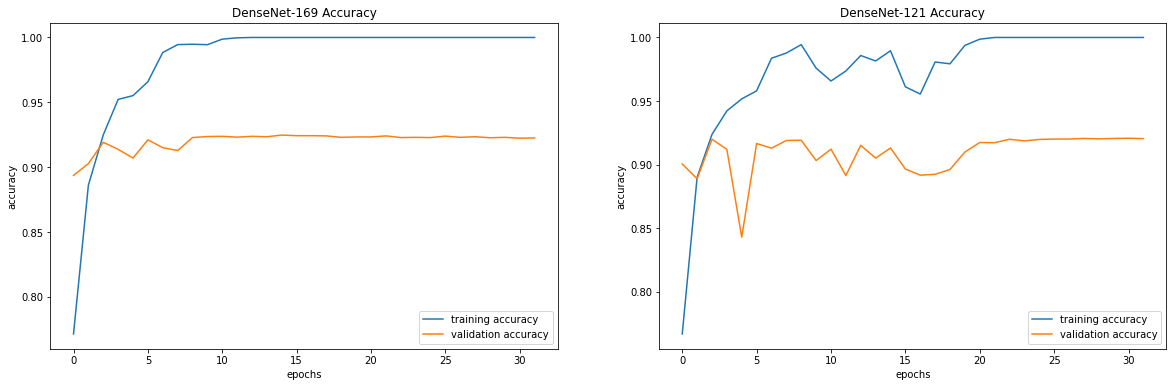

In [29]:
#plotting the training and test accuracy
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(fit_model.history['accuracy'], label = 'training accuracy')
plt.plot(fit_model.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('DenseNet-169 Accuracy')

plt.subplot(1, 2, 2)
plt.plot(fit_model2.history['accuracy'], label = 'training accuracy')
plt.plot(fit_model2.history['val_accuracy'], label = 'validation accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('DenseNet-121 Accuracy')

Text(0.5, 1.0, 'DenseNet-121 Loss')

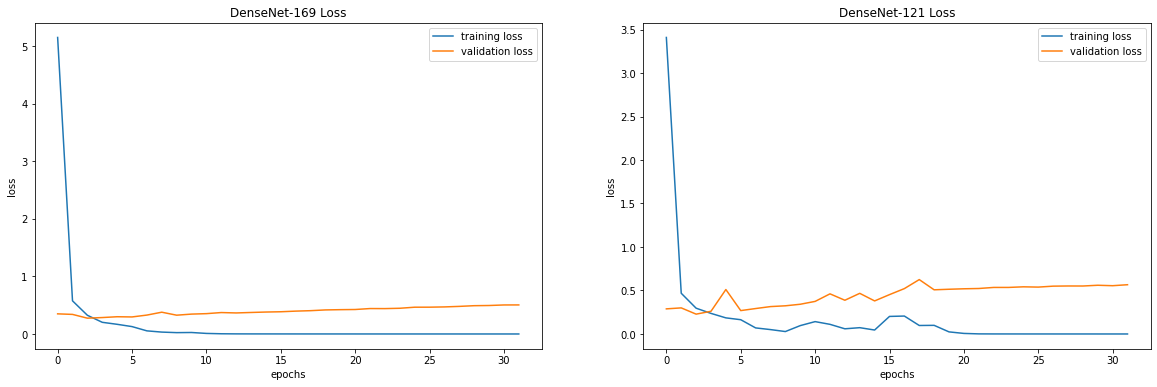

In [39]:
#plotting the training and test loss
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(fit_model.history['loss'], label = 'training loss')
plt.plot(fit_model.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('DenseNet-169 Loss')

plt.subplot(1, 2, 2)
plt.plot(fit_model2.history['loss'], label = 'training loss')
plt.plot(fit_model2.history['val_loss'], label = 'validation loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('DenseNet-121 Loss')

Text(0.5, 1.0, 'DenseNet-121 MSE')

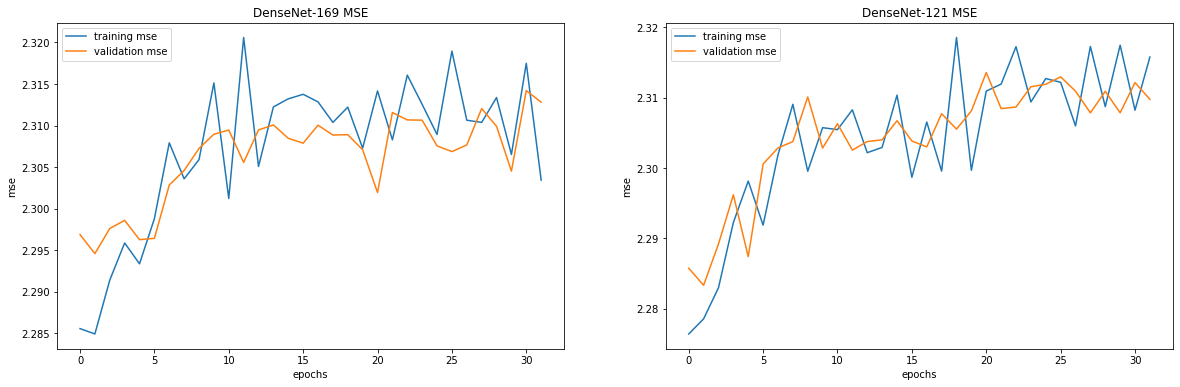

In [40]:
#plotting the training and test mse
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
plt.plot(fit_model.history['mse'], label = 'training mse')
plt.plot(fit_model.history['val_mse'], label = 'validation mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('DenseNet-169 MSE')

plt.subplot(1, 2, 2)
plt.plot(fit_model2.history['mse'], label = 'training mse')
plt.plot(fit_model2.history['val_mse'], label = 'validation mse')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('mse')
plt.title('DenseNet-121 MSE')

The DenseNet-169 model performs slightly better than the DenseNet-121 in both the accuracy and loss. 

## 5.4 Validation Set<a id='5.4_Validation_Set'></a>

In [41]:
loss, accuracy, mse = model.evaluate(val_ds, batch_size = batch_size, steps = (val_count // batch_size))

49/49 [==============================] - 7s 140ms/step - loss: 0.5099 - accuracy: 0.9222 - mse: 2.3114


## 5.5 Summary<a id='5.5_Summary'></a>
The DenseNet-169 model performed with 92% accuracy on the validation set which surpassed my goal of 85%. 